<!--NOTEBOOK_INFORMATION-->
<img align="left" style="padding-right:10px;" src="./figures/LogoOpenclassrooms.png">
<font size="4">
<p>
Cette étude a été réalisée dans le cadre du 5ème projet de ma formation Datascientist dispensée en MOOC par 
**<font color='blus'>Openclassrooms / écoles Centrale-Supélec</font>**.
</p>    

<p>
Les données étudiées dans ce noteboook sont fournies par le site :
</p>
<p>
https://archive.ics.uci.edu/ml/datasets/Online+Retail
</p>
<p>
Ce notebook implémente les phases de l'analyse exploratoire de la façon suivante :
</p>
* l'acquisition des données
* le nettoyage des données    
* l'analyse exploratoire des données    


**Les résultats des traitements effectués dans ce notebook sont repris dans les notebook **

* <font color='blue'>*P5_2_timeFeature.ipynb*</font>. 

* <font color='blue'>*P5_2_RFM.ipynb*</font>. 

* <font color='blue'>*P5_2_NLP.ipynb*</font>. 

* <font color='blue'>*P5_2_AllFeature.ipynb*</font>. 


In [1]:
import pandas as pd
import numpy as np
import time

import p3_util
import p3_util_plot
import p5_util
import p5_util_plot

#--------------------------
# Process flow parameters
#--------------------------
is_reloaded = False

#---------------------------------------------------------------------------
# Outliers values issued from Total feature are removed or not from dataset.
is_total_no_outliers = False
#---------------------------------------------------------------------------

#---------------------------------------------------------------------------
# Encoded RFM features are clusterized separatly from other features.
#---------------------------------------------------------------------------
is_rfm_cluster = True


# <font color='blues'>Data preparation</font>

On s'est assuré qu'i n'y avait qu'un seul onglet dans le fichier.

## <font color='blue'>Data reading</font>

In [2]:
fileName = './data/OnlineRetail.xlsx'
t0 = time.time()
df_invoice_line = pd.read_excel(fileName)
t1 = time.time()
print("Elapsed time = %1.2f" %(t1-t0))

Elapsed time = 43.41


# <font color='blus'>Data cleaning</font>

 * Les lignes contenant les customers ID a Nan sont purgées.
 * Les lignes contenant des variables aberrantes sont purgées

In [3]:
print(df_invoice_line.shape)
df_invoice_line.sample(3)

(541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
310991,564221,22433,WATERING CAN GREEN DINOSAUR,1,2011-08-24 09:36:00,4.13,NaN,United Kingdom
90714,544064,82486,WOOD S/3 CABINET ANT WHITE FINISH,1,2011-02-15 13:50:00,8.95,17114.0,United Kingdom
64904,541681,22554,PLASTERS IN TIN WOODLAND ANIMALS,12,2011-01-20 14:24:00,1.65,13008.0,United Kingdom


**Description des variables quantitatives**

In [4]:
df_invoice_line.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


* **Drop duplicated rows**

In [5]:
df_invoice_line.columns
#df_invoice_line[['CustomerID','Country']].drop_duplicates()

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

* **Drop rows containing Nan values**

In [6]:
rows_before = df_invoice_line.shape[0]
print(df_invoice_line.shape)
df_invoice_line.dropna(axis=0, how='any', inplace=True)
print(df_invoice_line.shape)
rows_after = df_invoice_line.shape[0]
print("\n*** Nan values : Percent of dropped rows = %1.2F" %(np.abs(rows_before-rows_after)*100/rows_before))

(541909, 8)
(406829, 8)

*** Nan values : Percent of dropped rows = 24.93


* **Drop quantity <= 0**

In [7]:
rows_before = df_invoice_line.shape[0]
df_invoice_line = df_invoice_line[(df_invoice_line['Quantity']>0)]
rows_after = df_invoice_line.shape[0]
print("CustomerID <= 0 : Percent of dropped rows = %1.2F" %(np.abs(rows_before-rows_after)*100/rows_before))

CustomerID <= 0 : Percent of dropped rows = 2.19


* **Drop CustomerID <= 0**
* **Drop UnitPrice <=0**
* **Drop Quantity <=0**

In [8]:
df_invoice_line = df_invoice_line[df_invoice_line['CustomerID'] > 0]
print(df_invoice_line.shape)

df_invoice_line = df_invoice_line[df_invoice_line['UnitPrice']>0]
print(df_invoice_line.shape)

df_invoice_line = df_invoice_line[df_invoice_line['Quantity']>0]
print(df_invoice_line.shape)

(397924, 8)
(397884, 8)
(397884, 8)


* **Verification de l'existance de valeurs nulles dans chacune des colonnes et chacune des lignes**

In [9]:
# Verification sur toutes les lignes (axis=1) puis somme des résultats en colonne (axis=0)
df_invoice_line.isnull().sum(axis=1).sum(axis=0)

0

* **CustomerID is converted as integer**

In [10]:
df_invoice_line.CustomerID = df_invoice_line.CustomerID.astype(int)

In [11]:
nb_customers = len(df_invoice_line.CustomerID.unique())
print("\n*** Nombre de clients dans le dataset : "+str(nb_customers))


*** Nombre de clients dans le dataset : 4338


In [12]:
print(df_invoice_line.columns, df_invoice_line.shape)

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object') (397884, 8)


In [13]:
df_invoice_line.sample(1)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
442203,574667,21034,REX CASH+CARRY JUMBO SHOPPER,5,2011-11-06 12:12:00,0.95,15514,United Kingdom


#### <font color='blue'> Removing duplicated rows</font>

In [14]:
list_col_dupl = ['InvoiceNo','StockCode','InvoiceDate','Quantity','CustomerID']
print(df_invoice_line.shape)
df_invoice_line.drop_duplicates(subset=list_col_dupl, keep='first', inplace=True)
print(df_invoice_line.shape)

(397884, 8)
(392670, 8)


#### <font color='blue'>Countries are filtered</font>

In [38]:
if 'Country' in df_invoice_line.columns:
    df_invoice_line.Country.unique()

United Kingdom is the only country to be kept

In [39]:
print(df_invoice_line.shape)

df_invoice_line.query("Country == 'United Kingdom'", inplace=True)

print(df_invoice_line.shape)

if 'Country' in df_invoice_line:
    del(df_invoice_line['Country'])
print(df_invoice_line.shape)


(349189, 8)
(349189, 8)
(349189, 7)


#### <font color='blue'>Reset index </font>

In [40]:
df_invoice_line = df_invoice_line.reset_index()

del(df_invoice_line['index'])
df_invoice_line.sample(1)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
237949,569528,22867,HAND WARMER BIRD DESIGN,5,2011-10-04 14:53:00,2.1,16242


In [271]:
df_invoice_line.shape

(349189, 7)

In [42]:
nb_invoices = len(df_invoice_line['InvoiceNo'].unique())
print("\n*** Nombre de factures= "+str(nb_invoices))


*** Nombre de factures= 16646


In [43]:
nb_customers = len(df_invoice_line['CustomerID'].unique())
print("\n*** Nombre de clients= "+str(nb_customers))


*** Nombre de clients= 3920


#### <font color='blue'>Backup cleaned ``df_invoice_line`` dataframe</font>

In [44]:
import p5_util
file_name = './data/df_invoice_line_clean.dump'
p5_util.object_dump(df_invoice_line, file_name)

### <font color='blue'>Sampling from *df_invoice_line* dataframe</font>

#### <font color='blue'>Restore cleaned dataframe</font>

In [263]:
import p5_util
is_reloaded = True
if is_reloaded is True:
    file_name = './data/df_invoice_line_clean.dump'
    df_invoice_line = p5_util.object_load(file_name)
    print(df_invoice_line.shape)    

(349189, 7)


#### <font color='blue'>Backup sampled dataframe</font>

In [46]:
import p5_util
col='CustomerID'
ratio = 0.80

df_invoice_line_sample = p5_util.df_sampling(df_invoice_line, 'CustomerID', ratio, mode='random')
print(df_invoice_line_sample.shape)
file_name = './data/df_invoice_line_sample_random.dump'
p5_util.object_dump(df_invoice_line_sample, file_name)

(194907, 7)


In [274]:
df_invoice_line_sample.InvoiceDate.max()

Timestamp('2011-12-09 12:49:00')

#### <font color='blue'>Backup out of sampling dataframe</font>

In [269]:
import numpy as np

import p5_util

# Get customerID from sampling
arr_sample_customerID = np.unique(df_invoice_line_sample.CustomerID.values)

# Query cleaned dataframe with customerID out of sample
df_query = "CustomerID not in "+str(list(arr_sample_customerID))
df_invoice_line_out_sample = df_invoice_line.query(df_query)

# Dump out of sample customerID dataframe
file_name = './data/df_invoice_line_out_sample_random.dump'
p5_util.object_dump(df_invoice_line_out_sample, file_name)

In [255]:
df_invoice_line_sample.shape

(194907, 7)

In [257]:
print("Max date from sample = "+str(df_invoice_line_sample.InvoiceDate.max()))

Max date from sample = 2011-12-09 12:49:00


In [50]:
nb_invoices = len(df_invoice_line_sample['InvoiceNo'].unique())
print("\n*** Nombre de factures du sample= "+str(nb_invoices))


*** Nombre de factures du sample= 9330


In [51]:
nb_customers = len(df_invoice_line_sample['CustomerID'].unique())
print("\n*** Nombre de clients du sample= "+str(nb_customers))


*** Nombre de clients du sample= 2124


# <font color='blus'>Data exploration</font>

In [58]:
import p5_util
if is_reloaded is True:
    file_name = './data/df_invoice_line_sample_random.dump'
    df_invoice_line = p5_util.object_load(file_name)
    print(df_invoice_line.shape)    

(194907, 7)


### Features

In [59]:
df_invoice_line.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID'],
      dtype='object')

#### Exploration of activity per period of time

In [62]:
import p5_util
dict_period_function={'year':p5_util.p5_get_year_from_timestamp}
dict_period_function['month'] = p5_util.p5_get_month_from_timestamp
dict_period_function['day'] = p5_util.p5_get_day_from_timestamp
dict_period_function['dow'] = p5_util.p5_get_dow_from_timestamp
dict_period_function['pod'] = p5_util.p5_get_pod_from_timestamp

for new_time_feature, time_function in dict_period_function.items() :
    print("New time feature : "+str(new_time_feature))
    df_invoice_line[new_time_feature] = df_invoice_line['InvoiceDate'].apply(time_function)


New time feature : year
New time feature : month
New time feature : day
New time feature : dow
New time feature : pod


#### Activities against new features based on time

In [95]:
df = df_invoice_line.groupby(['year','InvoiceNo']).agg({'InvoiceNo': lambda x:len(x)})

df.rename(columns={'InvoiceNo':'InvoiceCount'}, inplace=True)
df.reset_index(inplace=True)
df = df.groupby(['year']).agg({'InvoiceCount': lambda x:sum(x)})
df.rename(columns={'InvoiceCount':'Yearly Facturation'}, inplace=True)
print(df)

      Yearly Facturation
year                    
2010               12954
2011              181953


In [180]:
df = df_invoice_line.groupby(['pod','InvoiceNo']).agg({'InvoiceNo': lambda x:len(x)})

df.rename(columns={'InvoiceNo':'InvoiceCount'}, inplace=True)
df.reset_index(inplace=True)
df = df.groupby(['pod']).agg({'InvoiceCount': lambda x:sum(x)})
df.rename(columns={'InvoiceCount':'POD Facturation'}, inplace=True)
print(df)

     POD Facturation
pod                 
1             192476
2               2431


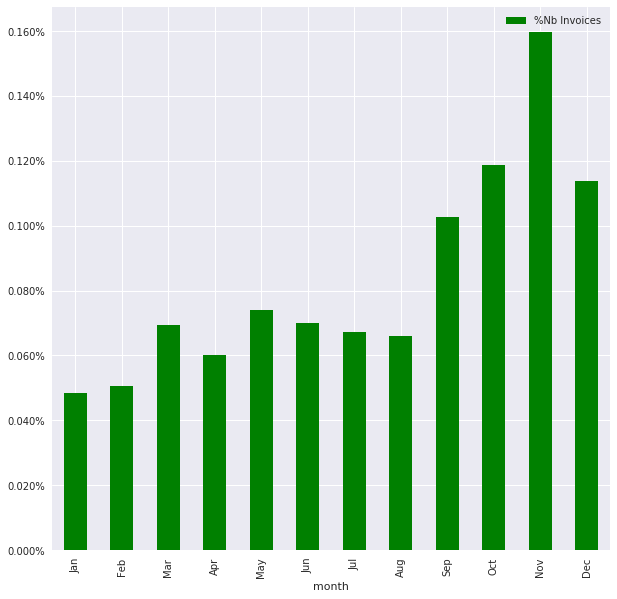

In [185]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

feature = 'month'
df = df_invoice_line.groupby([feature]).agg({'InvoiceNo': lambda x:len(x)})
df = df.apply(lambda x: x/sum(x))
df.rename(columns={'InvoiceNo':'%Nb Invoices'}, inplace=True)
dict_month_name={1:'Jan',2:'Feb', 3:'Mar', 4:'Apr',5:'May', 6:'Jun', 7:'Jul',8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
df.rename(dict_month_name,axis='index', inplace=True)

z_ = plt.figure(figsize=(10,10))
axes = plt.gca()
axes.set_xlabel('Months')
axes.yaxis.set_major_formatter(mtick.PercentFormatter())

df.plot(kind='bar', ax=axes, color='green')

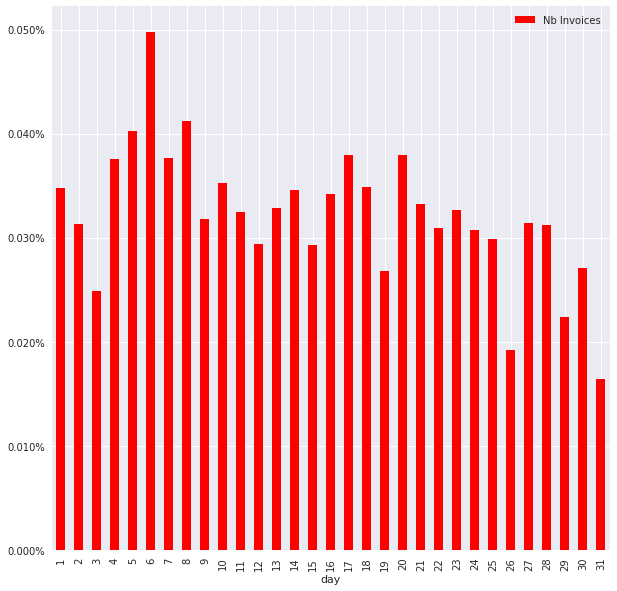

In [182]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

feature = 'day'
df = df_invoice_line.groupby([feature]).agg({'InvoiceNo': lambda x:len(x)})

if True:
    df.rename(columns={'InvoiceNo':'Nb Invoices'}, inplace=True)
    #dict_month_name={1:'Jan',2:'Feb', 3:'Mar', 4:'Apr',5:'May', 6:'Jun', 7:'Jul',8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
    #df.rename(dict_month_name,axis='index', inplace=True)
    df  = df.apply(lambda x: x/x.sum())

    z_ = plt.figure(figsize=(10,10))
    axes = plt.gca()
    axes.yaxis.set_major_formatter(mtick.PercentFormatter())

    df.plot(kind='bar', ax=axes, color='red')


In [169]:
import datetime
datetime.date(2002, 3, 11).timetuple()
df_invoice_line.query("dow==5")

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,year,month,day,dow,pod


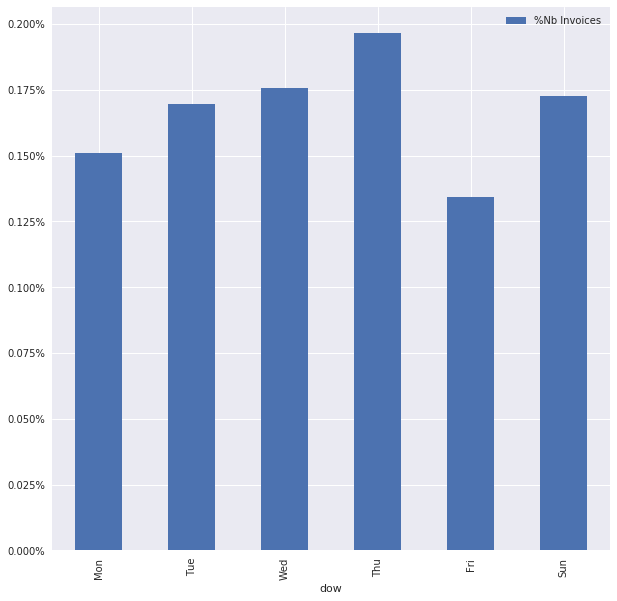

In [188]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

feature = 'dow'
df = df_invoice_line.groupby([feature]).agg({'InvoiceNo': lambda x:len(x)})

if True:
    df.rename(columns={'InvoiceNo':'%Nb Invoices'}, inplace=True)
    dict_dow_name={0:'Mon',1:'Tue', 2:'Wed', 3:'Thu',4:'Fri', 5:'Sat', 6:'Sun'}
    df.rename(dict_dow_name,axis='index', inplace=True)
    df  = df.apply(lambda x: x/x.sum())

    z_ = plt.figure(figsize=(10,10))
    axes = plt.gca()
    axes.yaxis.set_major_formatter(mtick.PercentFormatter())

    df.plot(kind='bar', ax=axes)


## Items analysys

In [211]:
import p3_util_plot
p3_util_plot.printmd("Nb of items : "+str(df_invoice_line.Description.unique().shape[0]))

<p><font color='green'>**Nb of items : 3672**</font></p>

In [235]:
import numpy as np

df_stock = df_invoice_line.groupby(['Description']).size().sort_values(ascending=False)
df_stock = df_invoice_line.groupby(['Description']).size()
df_stock.describe()
#df_stock.hist(bins=100)
print(df_stock.describe())

count    3672.000000
mean       53.079248
std        78.962266
min         1.000000
25%         7.000000
50%        25.000000
75%        67.000000
max      1040.000000
dtype: float64


In [236]:
import p5_util
list_no_words=['SET','PACK']
df_invoice_line, csr_matrix_weights, vectorizer \
= p5_util.nlp_process(df_invoice_line,'Description' ,list_no_words=list_no_words)

3672
3623
3616
3583
3581
3581
3576
3573
(194907, 1716)
Dumping matrix_weights into file= ./data/matrix_weights_NLP.dump
Done!


In [244]:
import numpy as np
matrix_weights_NLP = p5_util.object_load('./data/matrix_weights_NLP.dump')
weights = np.asarray(matrix_weights_NLP.mean(axis=0)).ravel().tolist()
df_weights = pd.DataFrame({'term': vectorizer.get_feature_names(), 'weight': weights})
print(df_weights.shape)
print(df_weights.sort_values(by='weight', ascending=False).head(20))


(1716, 2)
           term    weight
54          bag  0.035680
720       heart  0.030148
1255        red  0.028173
1273  retrospot  0.026195
1645     vintag  0.023591
433      design  0.022892
306    christma  0.019881
809       jumbo  0.018902
1148       pink  0.018790
158         box  0.018716
903       lunch  0.018340
866       light  0.017923
207        cake  0.017441
1670      white  0.015740
943       metal  0.015409
742      holder  0.014333
710        hang  0.014124
132        blue  0.013771
424       decor  0.013289
1383       sign  0.013169


# <font color='blus'>Feature engineering</font>

## <font color='blue'>For any invoice, Total price is added in feature *Total*</font>

In [ ]:
if 'Total' in df_invoice_line.columns :
    del(df_invoice_line['Total'])

df_invoice_line['Total'] = df_invoice_line.Quantity * df_invoice_line.UnitPrice
df_invoice_line = df_invoice_line[df_invoice_line['Total']>0]
print(df_invoice_line.shape)
df_invoice_line.sample(2)

### <font color='blue'>Oultliers in feature *Total*</font>

In [ ]:
import p5_util_plot

p5_util_plot.p5_df_subplot(df_invoice_line[['Quantity','UnitPrice','Total']],\
                           type_plot='box', is_outliers_removed = True, tuple_reshape=(1,3))

### <font color='blue'>Outliers from *Total* feature are dropped</font>

In [ ]:
import p3_util
if is_total_no_outliers is True:
    zmin, zmax = p3_util.df_boxplot_min_max(df_invoice_line , 'Total')

    print(df_invoice_line.shape)
    df_invoice_line = df_invoice_line[df_invoice_line['Total']>=zmin]

    print(df_invoice_line.shape)

    df_invoice_line = df_invoice_line[df_invoice_line['Total']<=zmax]
    print(df_invoice_line.shape)


#### <font color='blue'>Backup cleaned dataframe #1</font>

In [ ]:
import p5_util

fileName = './data/df_invoice_line_clean1.dump'
p5_util.object_dump(df_invoice_line,fileName)

#### <font color='blue'>Restore cleaned dataframe #1</font>

In [ ]:
import p5_util

if is_reloaded is True:
    fileName = './data/df_invoice_line_clean1.dump'
    df_invoice_line = p5_util.object_load(fileName)
    print(df_invoice_line.shape)

In [ ]:
df_invoice_line.columns